In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#pip install spectrum_utils

In [3]:
#pip install pyteomics

In [4]:
#!pip install rdkit

In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

In [6]:
import logging
from typing import Dict, IO, Iterator, Sequence, Union
from pyteomics import mgf
import pyteomics
from spectrum_utils.spectrum import MsmsSpectrum
import matplotlib.pyplot as plt
import spectrum_utils.plot as sup
import spectrum_utils as su
import numpy as np
from src.load_data import LoadData
from spectrum_utils import plot
from src.preprocessor import Preprocessor
from src.ml_model import MlModel
from src.tanimoto import Tanimoto
from sklearn.model_selection import train_test_split
from src.plotting import Plotting
import pickle
from src.cosine_distance import CosineDistance

In [7]:
from tqdm import tqdm

In [8]:
from src.spectrum_ext import SpectrumExt

In [9]:
from src.train_utils import TrainUtils
from sklearn.metrics import r2_score

In [10]:
pp =Preprocessor()

In [11]:
## THINGS TO DO:
# ADD ADITIONAL VARIABLES TO VECTOR
# TRAIN FOR MORE TIME

## Load data

In [12]:
import pickle

# Load the dataset from the pickle file
with open('./dataset_processed.pkl', 'rb') as file:
    dataset = pickle.load(file)

# Now you can access the original variables from the dataset dictionary
all_spectrums_train = dataset['all_spectrums_train']
all_spectrums_test = dataset['all_spectrums_test']
molecule_pairs_train = dataset['molecule_pairs_train']
molecule_pairs_test = dataset['molecule_pairs_test']


## Get vectors

## Get high pairs and low paris

In [13]:
molecule_pairs_train_high = [m for m in molecule_pairs_train if m.similarity==1]

In [14]:
len(molecule_pairs_train_high)

5275

In [15]:
molecule_pairs_train_low = [m for m in molecule_pairs_train if m.similarity<0.035]

In [16]:
len(molecule_pairs_train_low)

4959

## Merge data

In [17]:
molecule_pairs_merged = molecule_pairs_train_high + molecule_pairs_train_low


In [18]:
# insert spectrum vectors
molecule_pairs_merged = TrainUtils.insert_spectrum_vector_into_molecule_pairs(molecule_pairs_merged)

In [19]:
molecule_pairs_merged_train, molecule_pairs_merged_test = train_test_split(molecule_pairs_merged)

## Show np vectors

## Cosine analysis

In [20]:
similarity_results = np.array([m.similarity for m in molecule_pairs_merged_train])

In [21]:
cos_results = np.array([CosineDistance.compute_cosine_distance(m.vector_0, m.vector_1) for m in molecule_pairs_merged_train])
cos_results=np.nan_to_num(cos_results, nan=0)

C:\Users\ramir\projects\metabolomics_experiments\src\cosine_distance.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return dot_product / (norm_array1 * norm_array2)


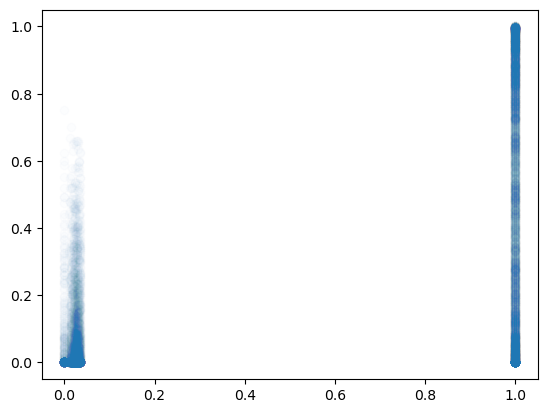

In [22]:
plt.scatter(similarity_results, cos_results, alpha=0.01)

In [23]:
r2_score(similarity_results, cos_results)

0.038819534224568186

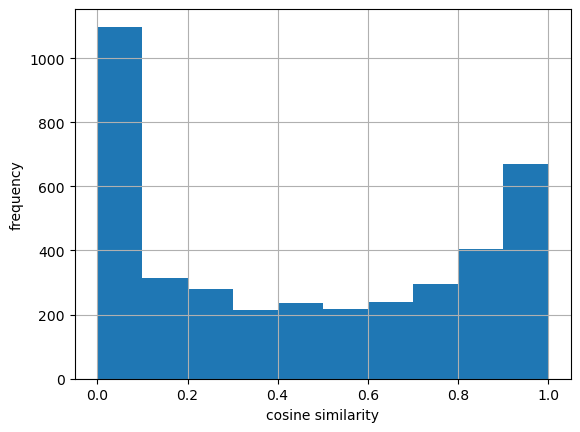

In [38]:
plt.hist(cos_results[similarity_results==1])
plt.ylabel('frequency')
plt.xlabel('cosine similarity')
plt.grid()

## Training

In [25]:
model = MlModel(input_dim=molecule_pairs_merged_train[0].vector_0.shape[0])

In [26]:
model.compile()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 991)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 991)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                            

In [27]:
model.fit(molecule_pairs_merged_train, epochs=100)

Epoch 1/100
190/192 [============================>.] - ETA: 0s - loss: 0.3074 - mse: 0.3074
Epoch 1: val_mse improved from inf to 0.41597, saving model to best_model.h5
192/192 [==============================] - 12s 30ms/step - loss: 0.3072 - mse: 0.3072 - val_loss: 0.4160 - val_mse: 0.4160
Epoch 2/100
 31/192 [===>..........................] - ETA: 0s - loss: 0.2894 - mse: 0.2894

C:\Users\ramir\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/192 [===========================>..] - ETA: 0s - loss: 0.2756 - mse: 0.2756
Epoch 2: val_mse did not improve from 0.41597
192/192 [==============================] - 5s 24ms/step - loss: 0.2751 - mse: 0.2751 - val_loss: 0.4327 - val_mse: 0.4327
Epoch 3/100
187/192 [============================>.] - ETA: 0s - loss: 0.2578 - mse: 0.2578
Epoch 3: val_mse did not improve from 0.41597
192/192 [==============================] - 3s 17ms/step - loss: 0.2575 - mse: 0.2575 - val_loss: 0.4323 - val_mse: 0.4323
Epoch 4/100
183/192 [===========================>..] - ETA: 0s - loss: 0.2533 - mse: 0.2533
Epoch 4: val_mse did not improve from 0.41597
192/192 [==============================] - 3s 15ms/step - loss: 0.2525 - mse: 0.2525 - val_loss: 0.4262 - val_mse: 0.4262
Epoch 5/100
187/192 [============================>.] - ETA: 0s - loss: 0.2499 - mse: 0.2499
Epoch 5: val_mse improved from 0.41597 to 0.41070, saving model to best_model.h5
192/192 [==============================] - 3s 15ms/step - l

Epoch 31/100
184/192 [===========================>..] - ETA: 0s - loss: 0.1940 - mse: 0.1940
Epoch 31: val_mse did not improve from 0.22787
192/192 [==============================] - 3s 15ms/step - loss: 0.1940 - mse: 0.1940 - val_loss: 0.2288 - val_mse: 0.2288
Epoch 32/100
186/192 [============================>.] - ETA: 0s - loss: 0.1913 - mse: 0.1913
Epoch 32: val_mse improved from 0.22787 to 0.22721, saving model to best_model.h5
192/192 [==============================] - 3s 15ms/step - loss: 0.1910 - mse: 0.1910 - val_loss: 0.2272 - val_mse: 0.2272
Epoch 33/100
187/192 [============================>.] - ETA: 0s - loss: 0.1896 - mse: 0.1896
Epoch 33: val_mse did not improve from 0.22721
192/192 [==============================] - 3s 15ms/step - loss: 0.1891 - mse: 0.1891 - val_loss: 0.2325 - val_mse: 0.2325
Epoch 34/100
186/192 [============================>.] - ETA: 0s - loss: 0.1893 - mse: 0.1893
Epoch 34: val_mse did not improve from 0.22721
192/192 [==============================

188/192 [============================>.] - ETA: 0s - loss: 0.1800 - mse: 0.1800
Epoch 62: val_mse did not improve from 0.22721
192/192 [==============================] - 3s 17ms/step - loss: 0.1799 - mse: 0.1799 - val_loss: 0.2362 - val_mse: 0.2362
Epoch 63/100
184/192 [===========================>..] - ETA: 0s - loss: 0.1820 - mse: 0.1820
Epoch 63: val_mse did not improve from 0.22721
192/192 [==============================] - 3s 15ms/step - loss: 0.1816 - mse: 0.1816 - val_loss: 0.2370 - val_mse: 0.2370
Epoch 64/100
185/192 [===========================>..] - ETA: 0s - loss: 0.1812 - mse: 0.1812
Epoch 64: val_mse did not improve from 0.22721
192/192 [==============================] - 3s 16ms/step - loss: 0.1812 - mse: 0.1812 - val_loss: 0.2355 - val_mse: 0.2355
Epoch 65/100
184/192 [===========================>..] - ETA: 0s - loss: 0.1851 - mse: 0.1851
Epoch 65: val_mse did not improve from 0.22721
192/192 [==============================] - 3s 18ms/step - loss: 0.1844 - mse: 0.1844 - 

180/192 [===========================>..] - ETA: 0s - loss: 0.1777 - mse: 0.1777
Epoch 93: val_mse did not improve from 0.22721
192/192 [==============================] - 3s 18ms/step - loss: 0.1774 - mse: 0.1774 - val_loss: 0.2378 - val_mse: 0.2378
Epoch 94/100
182/192 [===========================>..] - ETA: 0s - loss: 0.1755 - mse: 0.1755
Epoch 94: val_mse did not improve from 0.22721
192/192 [==============================] - 3s 15ms/step - loss: 0.1752 - mse: 0.1752 - val_loss: 0.2412 - val_mse: 0.2412
Epoch 95/100
178/192 [==========================>...] - ETA: 0s - loss: 0.1753 - mse: 0.1753
Epoch 95: val_mse did not improve from 0.22721
192/192 [==============================] - 3s 15ms/step - loss: 0.1757 - mse: 0.1757 - val_loss: 0.2378 - val_mse: 0.2378
Epoch 96/100
192/192 [==============================] - ETA: 0s - loss: 0.1733 - mse: 0.1733
Epoch 96: val_mse did not improve from 0.22721
192/192 [==============================] - 3s 16ms/step - loss: 0.1733 - mse: 0.1733 - 

In [28]:
model.load_best_model()

## Performance

In [29]:
prediction_results_train = model.predict(molecule_pairs_merged_train)

240/240 [==============================] - 6s 2ms/step


(array([1426.,  665.,  194.,  107.,  100.,   95.,  112.,  129.,  209.,
        4638.]),
 array([0.00910435, 0.10819393, 0.20728353, 0.30637312, 0.40546271,
        0.5045523 , 0.60364187, 0.70273149, 0.80182105, 0.90091068,
        1.00000024]),
 <BarContainer object of 10 artists>)

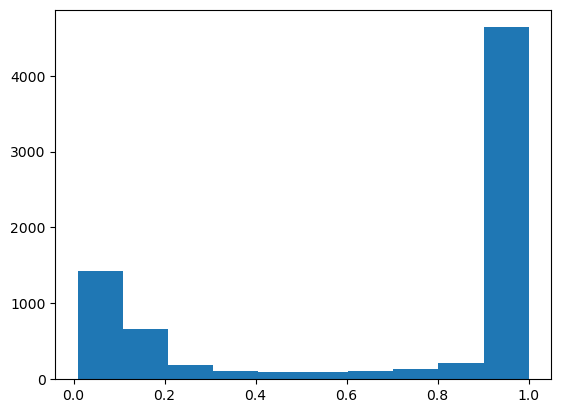

In [30]:
plt.hist(prediction_results_train, bins=10)

In [31]:
prediction_results_test = model.predict(molecule_pairs_merged_test)

80/80 [==============================] - 4s 2ms/step


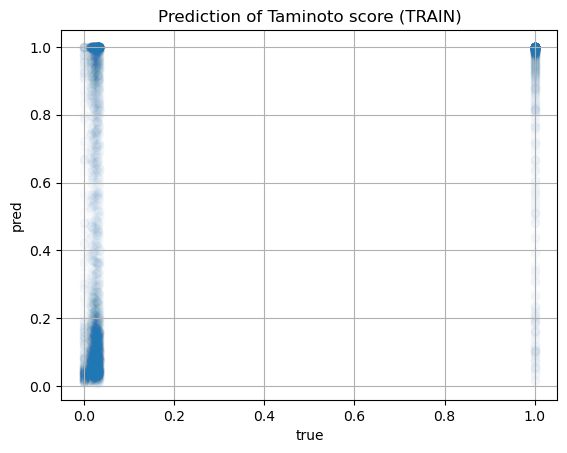

In [32]:
similarity_train =[m.similarity for m in molecule_pairs_merged_train]
plt.scatter(similarity_train, prediction_results_train, alpha=0.01)
plt.title('Prediction of Taminoto score (TRAIN)')
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()

In [33]:
r2_score(similarity_train, prediction_results_train)

0.3636419486014717

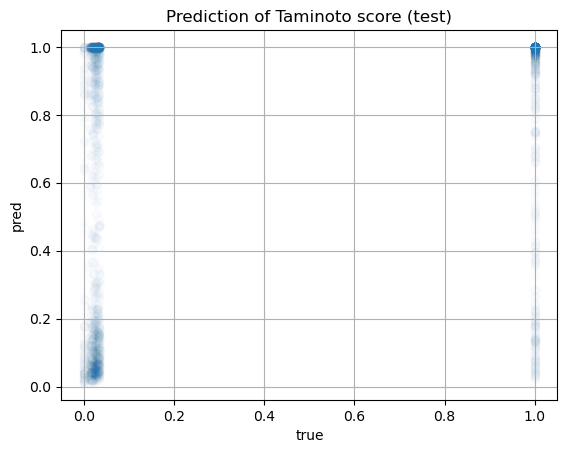

In [34]:
similarity_test= [m.similarity for m in molecule_pairs_merged_test]
plt.scatter(similarity_test, prediction_results_test, alpha=0.01)
plt.title('Prediction of Taminoto score (test)')
plt.xlabel('true')
plt.ylabel('pred')
plt.grid()

In [35]:
r2_score(similarity_test, prediction_results_test)

-0.0012273870699959222